In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp
from datetime import datetime
from MCEq.core import MCEqRun
import mceq_config
from MCEq.geometry.density_profiles import EarthsAtmosphere, CorsikaAtmosphere
import crflux.models as crf
from atm import read_station_data, RWSAtmosphere, RWSim

# Radiosonde Atmospheres

## Key West Data
The stations are cyptically coded. Key West is USM00072201, for example. There's a stagion decoder also available on the NCEI site. It seems that the data is segmented into new, for the past 3 years, and prior data.

In [4]:
rw_keyw = list(read_station_data('/mnt/w/data/radiosonde/USM00072201-data.txt'))

## South Pole data
South Pole (AMUNDSEN SCOTT) is __AYM00089009__. It's notably different from at least Key West as the data is only reported at regular pressure intervals (500, 400, ... etc). I changed around the `Rawinsonde` classt to make dealing with missing data less onerous.

In [5]:
RW89009 = list(read_station_data('/mnt/w/data/radiosonde/AYM00089009-data.txt'))

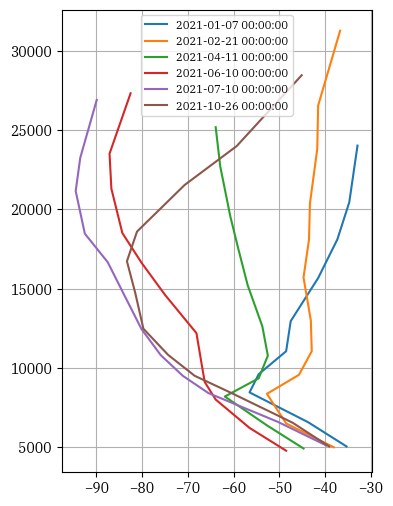

In [7]:
plt.figure(figsize=(4, 6))
for iobs in (7, 75, 157, 212, 245, 376):
    r = RW89009[iobs]
    obs = r.valid
    plt.plot(obs.temperature, obs.gph, label=str(r.dtime))
plt.legend(fontsize=8)

In [172]:
def cmp_flux(mceq, theta, *rwss):
    ref = None
    for r in rwss:
        mceq.set_density_model(RWSAtmosphere(r))
        mceq.set_theta_deg(theta)
        mceq.solve()
        flux = mceq.get_solution('total_mu+') + mceq.get_solution('total_mu-')
        if ref is None: 
            ref = np.copy(flux)
        else:
            plt.semilogx(mceq.e_grid, flux / ref)

## Let's Try Canada
Pickle Lake - gotta love that name.

In [10]:
pickle_lake = list(read_station_data('/mnt/w/data/radiosonde/CAM00071845-data.txt'))

(-75.0, 25.0, 0.0, 40.0)

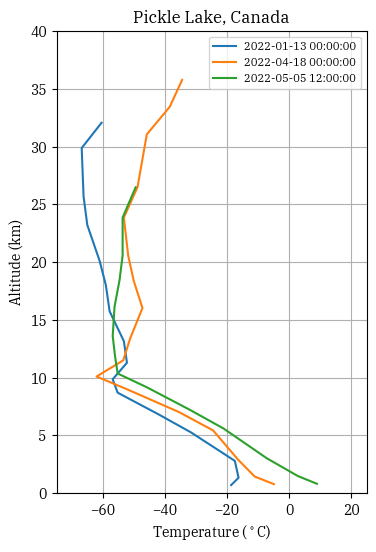

In [11]:
plt.figure(figsize=(4, 6))
iobs_set_01 = (7, 77, 221, 280, 444)
iobs_set_02 = (774, 777, 1055)
iobs_set_03 = (760, 950, 985)
for iobs in iobs_set_03:
    r = pickle_lake[iobs]
    obs = r.valid
    plt.plot(obs.temperature, obs.gph*0.001, label=str(r.dtime))
plt.legend(fontsize=8)
plt.title('Pickle Lake, Canada')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Altitude (km)')
plt.axis((-75, 25, 0, 40))

## San Diego Miramar
There's a flood advisory for 12/20/2023

In [8]:
miramar = list(read_station_data('/mnt/w/data/radiosonde/USM00072293-data.txt'))

(-80.0, 50.0, 0.0, 32.0)

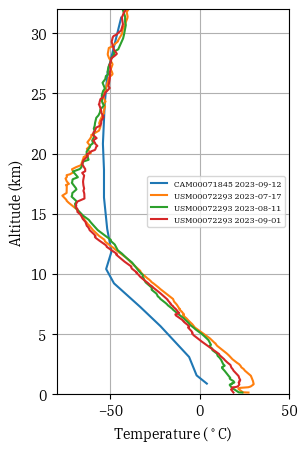

In [20]:
fig = plt.figure(figsize=(3,5))
r = pickle_lake[-200]
obs = r.valid
plt.plot(obs.temperature, obs.gph*0.001, label=r.st_id + str(r.dtime.date()))

for iobs in (-300, -250, -200):
    r = miramar[iobs]
    obs = r.valid
    plt.plot(obs.temperature, obs.gph*0.001, label=r.st_id + str(r.dtime.date()))
    
plt.legend(fontsize=6, loc=5)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Altitude (km)')
plt.axis((-80, 50, 0, 32))

## Jakarta, Indonesia
Tropical, maritime

In [ ]:
jakarta = list(read_station_data('/mnt/w/data/radiosonde/IDM00096749-data.txt'))

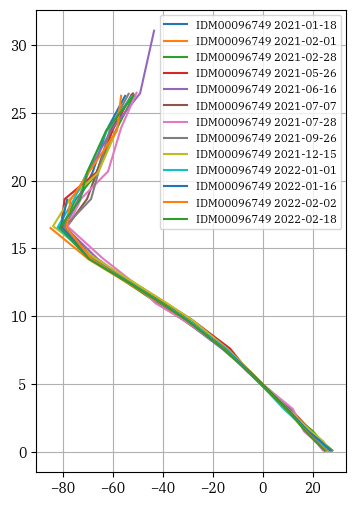

In [ ]:
plt.figure(figsize=(4, 6))
for iobs in range(10, 1200, 53):
    r = jakarta[iobs]
    obs = r.valid
    if len(obs) > 0:
        plt.plot(obs.temperature, obs.gph*0.001, label=r.st_id + str(r.dtime.date()))
plt.legend(fontsize=8)

## Random Atmosphere Generator

### Step 1: Choose the Station Altitude
Understand what the actual station altitude distribution looks like. We have the IGRA station list.

Text(0, 0.5, 'Frequency (a.u.)')

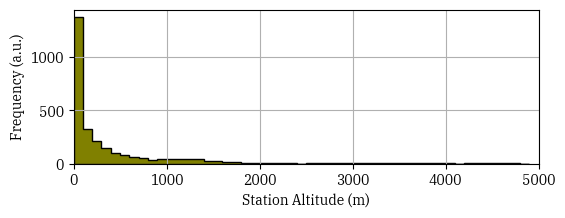

In [80]:
f = open('/mnt/w/data/radiosonde/igra2-station-list.txt', 'rt')
alt = []
for line in f.readlines():
    alt_txt = line[31:37]
    alt.append(float(alt_txt))

plt.figure(figsize=(6,2))
plt.hist(alt, bins=np.arange(0, 5000, 100), log=False, histtype='stepfilled', color='olive', ec='k');
plt.xlim(0, 5000)
plt.xlabel('Station Altitude (m)')
plt.ylabel('Frequency (a.u.)')

Surprisingly there are a lot of stations, airports presumably, at or within 100 m of sea level. There is another population of 1000-2000 m stations, I guess high plains, and then a long tail extending out to nearly 5000 m. Model this with an exponential + gaussian + uniform flat, with probabilities of 88%, 7%, and 5%, respectively.

In [87]:
a0 = np.random.uniform(0, 1, size=10000)
a1 = np.random.exponential(scale=150, size=10000)
a2 = np.random.normal(loc=1250, scale=250, size=10000)
a3 = np.random.uniform(0, 3000, size=10000)
alt = np.where(a0 > 0.95, a3, np.where(a0 > 0.88, a2, a1))

Text(0, 0.5, 'Frequency (a.u.)')

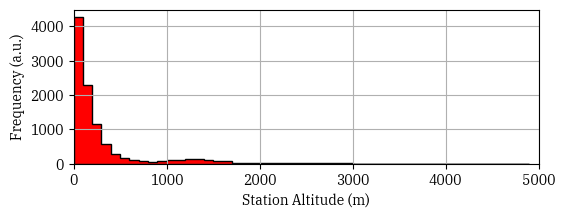

In [88]:
plt.figure(figsize=(6,2))
plt.hist(alt, bins=np.arange(0, 5000, 100), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlim(0, 5000)
plt.xlabel('Station Altitude (m)')
plt.ylabel('Frequency (a.u.)')

### Step 2: Choose a Sea Level Pressure

Text(0, 0.5, 'Frequency (a.u.)')

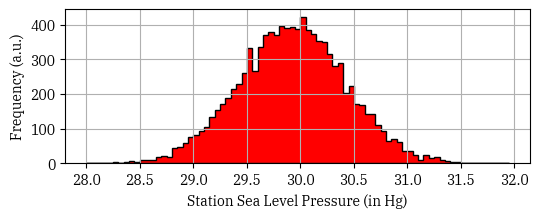

In [94]:
SLP = np.random.normal(loc=29.92, scale=0.5, size=10000)
plt.figure(figsize=(6,2))
plt.hist(SLP, bins=np.arange(28.0,32.0, 0.05), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlabel('Station Sea Level Pressure (in Hg)')
plt.ylabel('Frequency (a.u.)')

Text(0, 0.5, 'Frequency (a.u.)')

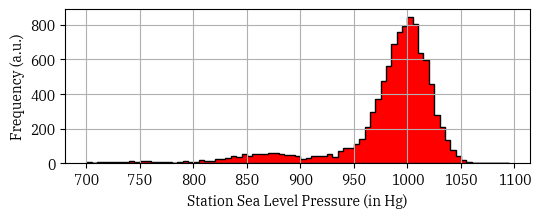

In [101]:
P0 = SLP * 33.87 * ((288.16 - 0.0065*alt) / 288.16)**5.26
plt.figure(figsize=(6,2))
plt.hist(P0, bins=np.arange(700, 1100, 5), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlabel('Station Sea Level Pressure (in Hg)')
plt.ylabel('Frequency (a.u.)')

### Temperature lapses
Model as lapse rate layers:

- -0.0065 +/- 0.001 in troposphere (0 AGL up to between 8 km and 15 km MSL)
- 2 layers in tropopause -0.001 to +0.001 (0 to 5 km thick)
- +0.001 to +0.0025 in lower stratosphere (up to 10 km thick)

In [248]:
NS = 20
temperature = np.zeros((5, NS), 'd')
gph = np.zeros((5, NS), 'd')
gph[0] = alt[0:NS]
temperature[0] = x = np.random.weibull(12, NS)*85 - 60

lapse_1 = -0.0065 + np.random.uniform(-0.0015, 0.0015, size=NS)
gph[1]  = np.random.uniform(8000, 15000, size=NS)
temperature[1] = temperature[0] + gph[1]*lapse_1

lapse_2 = np.random.uniform(-0.0005, 0.0005, size=NS)
gph[2]  = gph[1] + np.random.uniform(0, 5000, size=NS)
temperature[2] = temperature[1] + gph[2]*lapse_2

lapse_3 = np.random.uniform(-0.001, 0.001, size=NS)
gph[3]  = gph[2] + np.random.uniform(2000, 5000, size=NS)
temperature[3] = temperature[2] + gph[3]*lapse_3

lapse_4 = np.random.uniform(0.00025, 0.002, size=NS)
gph[4]  = gph[3] + np.random.uniform(5000, 15000, size=NS)
temperature[4] = temperature[3] + gph[4]*lapse_4



Text(0, 0.5, 'Altitude (km)')

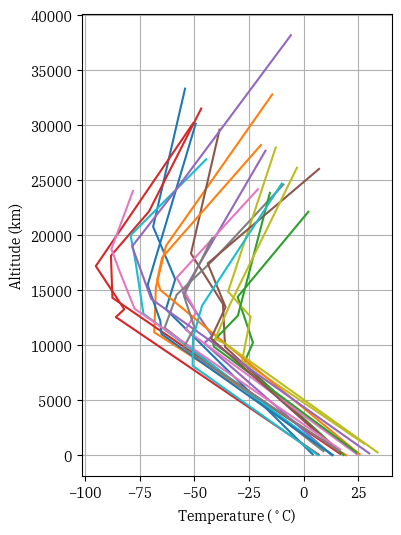

In [249]:
fig = plt.figure(figsize=(4,6))
for i in range(NS):
    plt.plot(temperature[:,i], gph[:,i])
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Altitude (km)')

### Putting It All Together
Encapsulate all of what was before into a class to generate everything upon instantiation of the class. 
The class should additionally expose attributes that make it look like a Rawinsonde so that it too can
be passed to the RWSAtmosphere class for MCEq. This has now been migrated to the package file `atm.py`.

Generate 5 random pseudo atmospheres.

(-100.0, 50.0, 0.0, 36000.0)

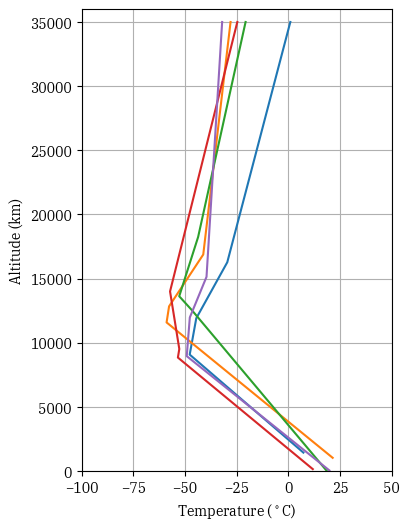

In [22]:
fig = plt.figure(figsize=(4,6))
for i in range(5):
    x = RWSim()
    plt.plot(x.valid.temperature, x.valid.gph)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Altitude (km)')
plt.axis((-100, 50, 0, 36000))

## On to Simulations

In [2]:
def simulate_atmosphere(r, theta, mceq=None):
    from MCEq.core import MCEqRun
    import crflux.models as crf
    if mceq is None: 
        mceq = MCEqRun(
            interaction_model='SIBYLL2.3c',
            primary_model = (crf.HillasGaisser2012, 'H3a'),
            theta_deg = 0.
        )
    theta = np.atleast_1d(theta)
    fluxes = []
    try:
        for t in theta:
            mceq.set_density_model(RWSAtmosphere(r))
            mceq.set_theta_deg(t)
            mceq.solve()
            fluxes.append(np.copy(mceq.get_solution('total_mu-') + mceq.get_solution('total_mu+')))
        fluxes = np.stack(fluxes, -1)
        return r, theta, fluxes
    except ValueError as err:
        return r, theta, err


In [ ]:
mceq = MCEqRun(
    interaction_model='SIBYLL2.3c',
    primary_model = (crf.HillasGaisser2012, 'H3a'),
    theta_deg = 0.
)
patterns = [simulate_atmosphere(RWSim(), theta=np.arange(0, 90, 30), mceq=mceq) for i in range(5)]